# Notebook description

NEF relies on two abstractions: 
 - The signal is encoded in the rate of the neuron.
 - The dynamics of the neuron soma do not affect the dynamics of the computation.

This notebook is for examining whether NEF works with neurons that spike at low rates. In this case, I found that the dynamics of the soma begin to affect the dynamics of the computation.

# Setup

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

import nengo
from nengo.synapses import filt
from nengo.utils.ensemble import tuning_curves
from nengo.utils.matplotlib import rasterplot
from nengo.utils.functions import piecewise

from nengo_QIF import QIF

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def spikes_to_decode(max_rate, tau, dt=.001,
                     neuron_type=nengo.LIF(), target_tau=None):
    """Utility for studying the relationship between spike rates, 
    filtering, and decode noise.
    
    Initializes the network with input x=0. Steps input to x=1.
        
    Parameters
    ----------
    max_rate : scalar
        maximum of rate distribution
    tau : scalar
        synaptic filter time constant
    neuron_type : nengo.LIF() or AdaptiveLIF()
        neuron model to use when building the Ensemble
    target_tau : float (optional)
        draw a target trajectory with this tau
    """
    
    T_init = 5./max_rate   # initialization time
    T_trans = 3*tau  # transient simulation time
    T = 10*tau + T_trans + T_init  # total simulation time
    
    x = 1.
    def in_fun(t):
        if t >= T_init:
            return x
        else:
            return 0.

    max_rates = nengo.dists.Uniform(1., max_rate)
    net = nengo.Network()
    with net:
        stim = nengo.Node(in_fun)
        out = nengo.Node(None, size_in=1)  # dummy Node to use as a connection target
        ens = nengo.Ensemble(200, 1, max_rates=max_rates, neuron_type=neuron_type)
        nengo.Connection(stim, ens, synapse=0.)
        conn = nengo.Connection(ens, out, synapse=0.)
        probe_d = nengo.Probe(ens, synapse=tau)  # probe the Ensemble's decoded output
        probe_s = nengo.Probe(ens.neurons, 'spikes')  # probe the spikes of the neurons
        probe_v = nengo.Probe(ens.neurons, 'voltage')
    # run simulation
    sim = nengo.Simulator(net, dt)
    sim.run(T, progress_bar=False)
    
    # extract data from simulation
    t = sim.trange()
    spikes = sim.data[probe_s]  # extract spike data
    encoders = sim.data[ens].encoders[:,0]
    rate_dat = filt(spikes, tau, dt)  # filter spikes to estimate rates
    probed_decode = sim.data[probe_d]
    probed_voltage = sim.data[probe_v]
        
    indices = np.argsort(encoders)
    filtered_step = np.zeros_like(t)
    filtered_step[t>=T_init] = 1-np.exp(-(t[t>=T_init]-T_init)/tau)
    if target_tau is not None:
        target_trajectory = np.zeros_like(t)
        target_trajectory[t>=T_init] = 1-np.exp(-(t[t>=T_init]-T_init)/target_tau)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,7), sharex=True)
    fig.subplots_adjust(top=.9, wspace=.2)
    rasterplot(t, spikes[:, indices], ax=axs[0,0])
    axs[0,0].set_ylabel('neuron index')
    axs[0,0].set_title('spike raster')
    axs[0,1].plot(t, rate_dat)
    axs[0,1].set_ylabel('estimated rates')
    axs[0,1].set_title('filtered spikes')
    axs[1,1].plot(t, probed_decode, 'b', lw=2, label='decode')
    axs[1,1].plot(t, filtered_step, 'g', label='filtered step')
    if target_tau is not None:
        axs[1,1].plot(t, target_trajectory, 'c', label='target trajectory')
    axs[1,1].legend(loc='lower right')
    axs[1,1].set_ylabel('decoded value')
    axs[1,1].set_title('decodes')
    axs[1,1].set_xlabel(r'time (s)')
    axs[1,0].pcolormesh(t, np.arange(200), probed_voltage[:, indices].T, cmap='winter')
    axs[1,0].invert_yaxis()
    axs[1,0].set_title('voltage')
    axs[1,0].set_ylabel('neuron index')
    axs[1,0].set_xlabel('time (s)')
    for ax in axs.flat:
        ax.axvline(T_init, c='r')

# Step response

First, we show what happens in the 'usual' case with LIF neurons that spike relatively quickly.

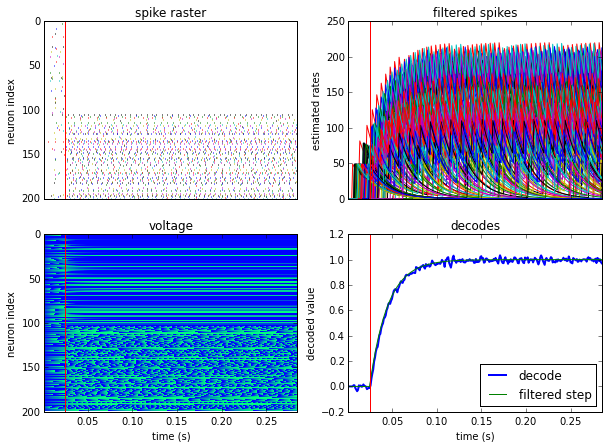

In [3]:
spikes_to_decode(200, .02);

Above, neurons are firing relatively. The filtered rates and decodes follow the saturating exponential trajectory that would be expected from filtering a step function.

Now, if we drop the spike rates, we'll see that the decode no longer follows the expected trajectory.

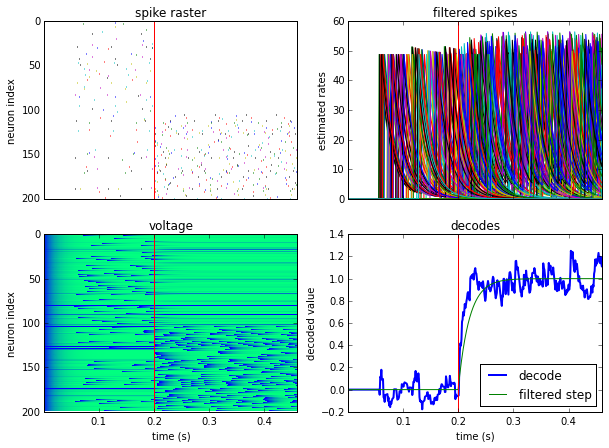

In [4]:
spikes_to_decode(25, .02);

With low rates, we can see that the voltages for slowly spiking neurons approach threhold slowly. When the input changes, all of these neurons all cross threshold and spike at similar times and cause the decode to overshoot the expected trajectory.

What about quadratic neurons?

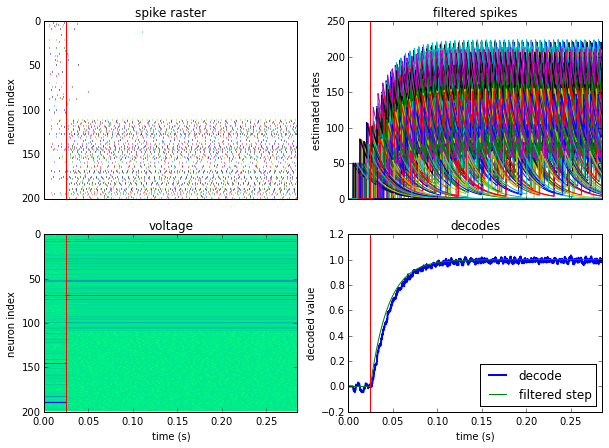

In [5]:
spikes_to_decode(200, .02, dt=.0001, neuron_type=QIF());

At high spike rates, the QIF ensemble decode follows the same trajectory as the LIF ensemble decode, perhaps with a slight latency shift because of the extra time it takes for the QIF neurons to reach spike threshold. 

Next, we'll run the QIF experiment using low spike rates.

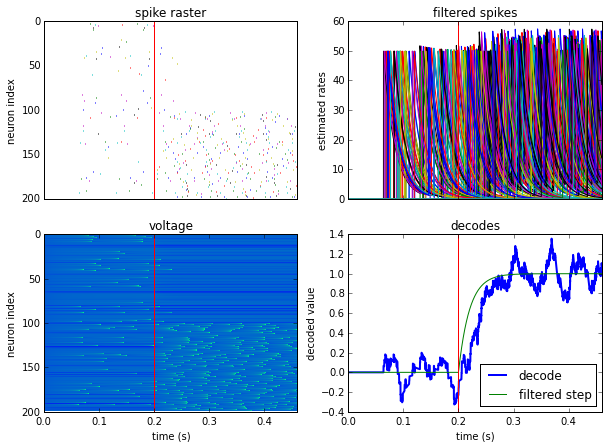

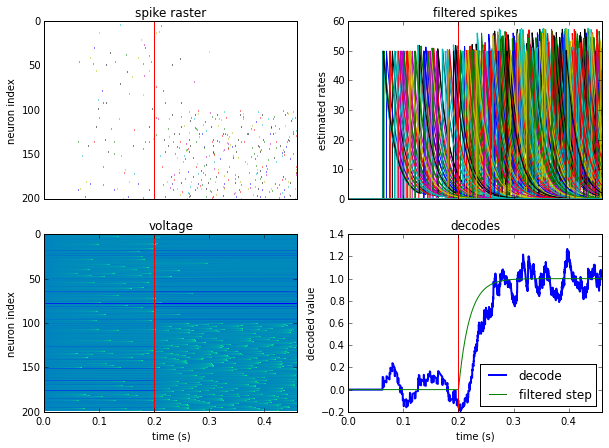

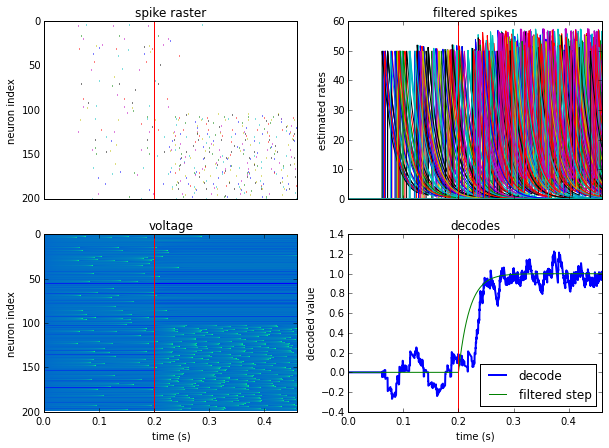

In [6]:
for i in xrange(3):  # run experiment 3 times
    spikes_to_decode(25, .02, dt=.0001, neuron_type=QIF());

At low spike rates, the QIF neuron ensemble decode deviates from the expected saturating exponential like the LIF neuron ensemble did. With both neuron models, the decode transitions from 0 to 1 more steeply than the saturating exponential. However, the QIF neuron model also introduces a lag into the decode transition.

# Step integration

Here, we look at whether the neural spike rates affect the performance NEF networks implementing an integrator. First, we run the integrator with high spike rates. Next, we reduce the spike rates of the individual neurons while increasing the number of of neurons so as to keep the same total spike rate and run the integrator again.

In [20]:
def build_integrator(in_fun, N, pstc, **ens_kwargs):
    net = nengo.Network()
    with net:
        stim = nengo.Node(in_fun)
        net.stim_probe = nengo.Probe(stim, synapse=0)
        
        net.ens = nengo.Ensemble(N, 1, **ens_kwargs)
        nengo.Connection(stim, net.ens, transform=pstc)
        nengo.Connection(net.ens, net.ens, synapse=pstc)
        net.ens_probe = nengo.Probe(net.ens, synapse=pstc)
        net.v_probe = nengo.Probe(net.ens.neurons, 'voltage')

        net.dm = nengo.Ensemble(1, 1, neuron_type=nengo.Direct())
        nengo.Connection(stim, net.dm, transform=pstc)
        nengo.Connection(net.dm, net.dm, synapse=pstc)
        net.dm_probe = nengo.Probe(net.dm, synapse=pstc)
    return net

def run_integrator(N, max_rate, dt, pstc, u=1., x_ss=1., **ens_kwargs):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 4), sharex=True)
    
    t_pulse = x_ss/u
    t_init = 5./max_rate
    T = t_init + 2*t_pulse
    in_fun = piecewise({0:0, t_init:u, t_init+t_pulse:0})
    
    net = build_integrator(in_fun, N, pstc, **ens_kwargs)
    sim = nengo.Simulator(net, dt=dt)
    sim.run(T, progress_bar=False)
    t = sim.trange()
    axs[0].plot(t, sim.data[net.stim_probe], 'k', label='stim')
    axs[0].plot(t, sim.data[net.dm_probe], 'g', label='integrated')
    axs[0].plot(t, sim.data[net.ens_probe], 'b', label='decoded')
    axs[0].legend(loc='best')
        
    indices = np.argsort(sim.data[net.ens].encoders[:,0])
    axs[1].pcolormesh(t, np.arange(N), sim.data[net.v_probe][:, indices].T, cmap='winter')
    for ax in axs:
        ax.axvline(t_init, c='r')
        ax.axvline(t_init+t_pulse, c='r')
        ax.set_xlim(0, T)
    return net, sim
        
def integrator_rate_exp(rate_high, N_high, k, neuron_type=nengo.LIF(),
                        dt=.001, pstc=.1):
    
    max_rates = nengo.dists.Uniform(1., rate_high)
    net, sim = run_integrator(N_high, rate_high, dt, pstc,
                              neuron_type=neuron_type, max_rates=max_rates)
    
    rate_low = rate_high / k
    N_low = N_high * k
    encoders = np.tile(sim.data[net.ens].encoders, (k, 1))
    max_rates = np.tile(sim.data[net.ens].max_rates/k, k)
    intercepts = np.tile(sim.data[net.ens].intercepts, k)
    run_integrator(N_low, rate_low, dt, pstc, neuron_type=neuron_type, 
                   encoders=encoders, max_rates=max_rates, intercepts=intercepts)
    

We'll run the experiment with LIF neurons and a synaptic time constant of $100$ms first.

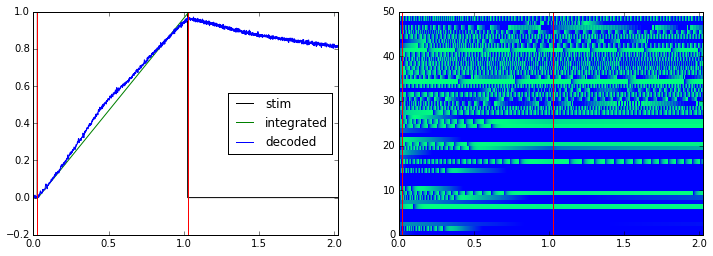

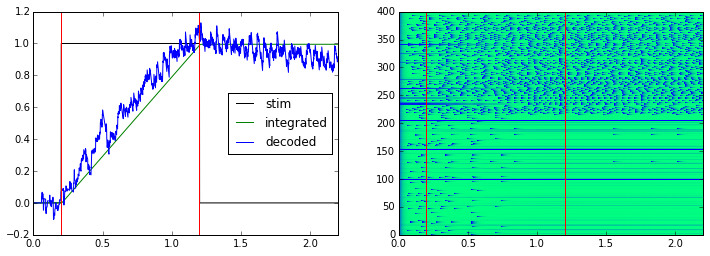

In [21]:
integrator_rate_exp(200, 50, 8, neuron_type=nengo.LIF(), pstc=.1)

The low spike rate network appears to follow the same dynamics, albeit with mroe noise. For constant total spike rate, we would expect the network with lower spike rate neurons to be more noisy because they have closer to Poisson statistics.

Now, we switch to QIF neurons.

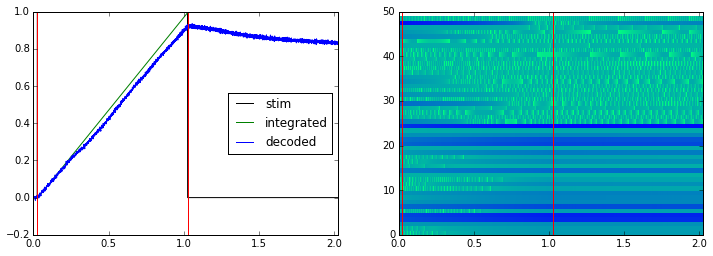

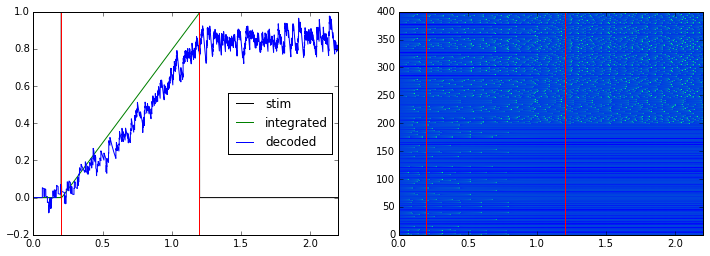

In [22]:
integrator_rate_exp(200, 50, 8, neuron_type=QIF(), dt=.0001, pstc=.1)

With QIF neurons, we see the same pattern as LIF neurons. The low spike rate version of the network follows the same dynamics but with more noise.

I think we can attribute the similarity between high and low spike rate dynamics to the long synaptic time constant used to implement the dynamics. Next, we'll reduce the synaptic time constant to $10$ms and see how our networks perform.

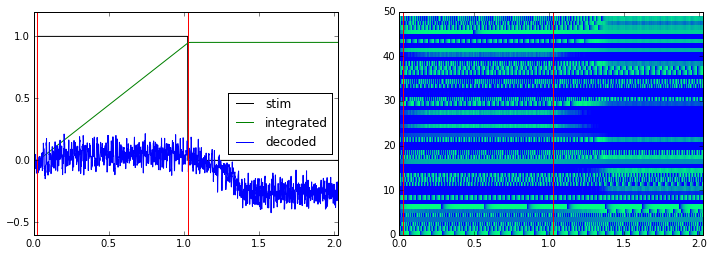

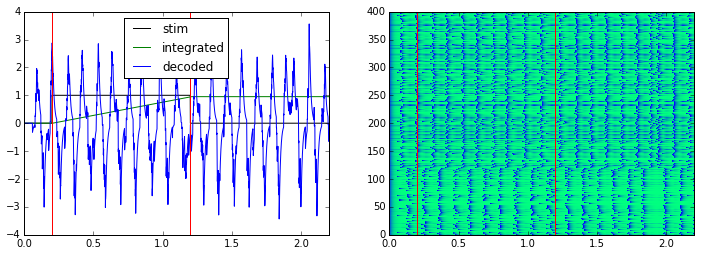

In [23]:
integrator_rate_exp(200, 50, 8, neuron_type=nengo.LIF(), pstc=.01)

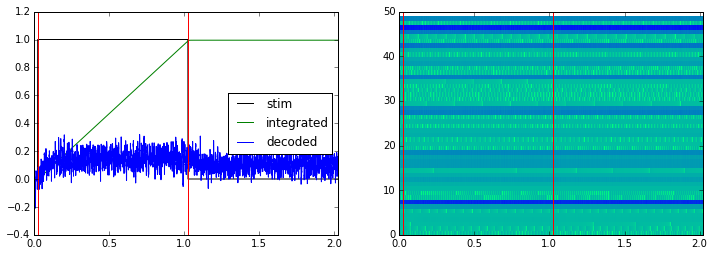

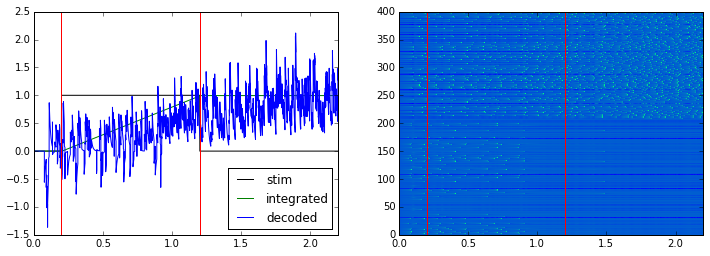

In [24]:
integrator_rate_exp(200, 50, 8, neuron_type=QIF(), dt=.0001, pstc=.01)

Looks like the network doesn't work any more...I should try restructuring the network so that the synapse appears before the ensemble.